In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd
from model.resnet import resnet152, resnet34

from utils.dataloader import CaptchaDataset

# hyperparameter

In [2]:
EPOCHS = 100
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'
MODEL_PATH = './weights/resnet34'
BATCH_SIZE = 1
PATIENCE = 10

# dataloader

In [3]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('./Large_Captcha_Dataset', isFilter=True, isCrop=True)

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# model

In [7]:
model = resnet34()

In [8]:
if CUDA:
    model = model.cuda()

# train

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [10]:
loss_history = []
val_loss_history = []

In [11]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

2/100, 1308.46 sec/epoch
stop cnt=1/10, current loss=12.1921, val loss=10.4579


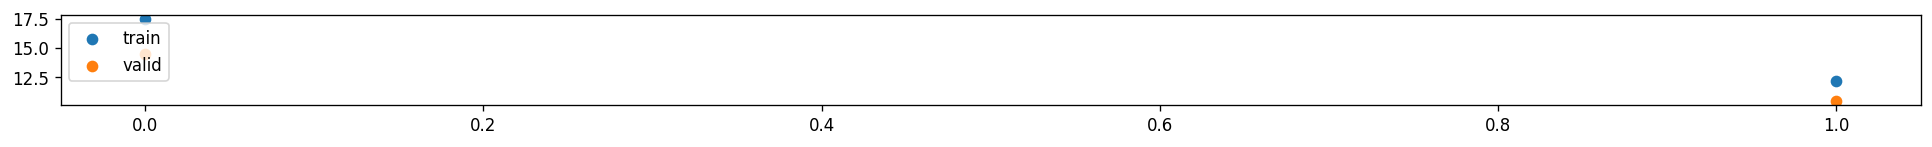

 97%|███████████████████████████████████▊ | 57356/59275 [21:16<00:44, 43.34it/s]

In [ ]:
min_val_loss = 20.
stop_cnt = 0
for e in range(EPOCHS):
    start_time = time.time()
    current_loss = []
    current_val_loss = []
    
    for (x, y) in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
        
        pred1, pred2, pred3, pred4, pred5 = model(x)

        loss1 = criterion(pred1, y1)
        loss2 = criterion(pred2, y2)
        loss3 = criterion(pred3, y3)
        loss4 = criterion(pred4, y4)
        loss5 = criterion(pred5, y5)
        loss = loss1 + loss2 + loss3 + loss4 + loss5
        current_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    current_loss = np.mean(current_loss).item()
    loss_history.append(current_loss)
    
    for (x, y) in tqdm(val_dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
            
            pred1, pred2, pred3, pred4, pred5 = model(x)
            
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_val_loss.append(loss.item())

    current_val_loss = np.mean(current_val_loss).item()
    val_loss_history.append(current_val_loss)
    
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        stop_cnt = 0
        torch.save(model.state_dict(), MODEL_PATH)
        
    stop_cnt += 1
    if stop_cnt == PATIENCE:
        break
    
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
    print(f"stop cnt={stop_cnt}/{PATIENCE}, current loss={current_loss:.4f}, val loss={current_val_loss:.4f}")
    plt.figure(figsize=(20,1),dpi=120)
    plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
    plt.scatter(np.arange(len(val_loss_history)), val_loss_history, label='valid')
    plt.legend(loc=2)
    plt.show()
    

33/100, 1706.36 sec/epoch
stop cnt=10/10, current loss=0.0393, val loss=0.3317


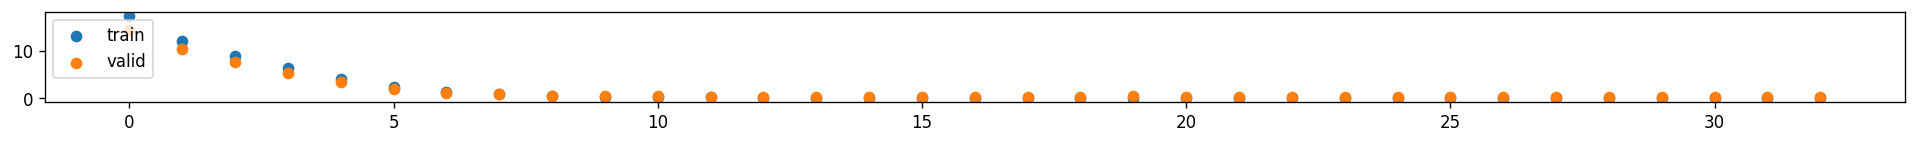

In [38]:
print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
print(f"stop cnt={stop_cnt}/{PATIENCE}, current loss={current_loss:.4f}, val loss={current_val_loss:.4f}")
plt.figure(figsize=(20,1),dpi=120)
plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
plt.scatter(np.arange(len(val_loss_history)), val_loss_history, label='valid')
plt.legend(loc=2)
plt.show()

# test

In [20]:
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))
'done'

'done'

In [21]:
pred_list = [[] for i in range(5)]
true_list = [[] for i in range(5)]

for (x, y) in tqdm(test_dataloader):
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        pred_list[0] += pred1.detach().cpu().tolist()
        pred_list[1] += pred2.detach().cpu().tolist()
        pred_list[2] += pred3.detach().cpu().tolist()
        pred_list[3] += pred4.detach().cpu().tolist()
        pred_list[4] += pred5.detach().cpu().tolist()
        
        true_list[0] += y1.detach().cpu().tolist()
        true_list[1] += y2.detach().cpu().tolist()
        true_list[2] += y3.detach().cpu().tolist()
        true_list[3] += y4.detach().cpu().tolist()
        true_list[4] += y5.detach().cpu().tolist()
        
        # print(pred_list)
        
        # for idx in range(BATCH_SIZE):
        #     plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        #     print(keys[y1[idx]], keys[y2[idx]], keys[y3[idx]], keys[y4[idx]], keys[y5[idx]])
        #     print(keys[pred1[idx]], keys[pred2[idx]], keys[pred3[idx]], keys[pred4[idx]], keys[pred5[idx]])
        #     break
        # break

100%|████████████████████████████████████| 16466/16466 [01:17<00:00, 211.79it/s]


In [23]:
pred_list = np.array(pred_list)
true_list = np.array(true_list)

In [24]:
(pred_list==true_list).shape

(5, 16466)

In [25]:
np.sum(pred_list==true_list, axis=1)/16466

array([0.84167375, 0.8213288 , 0.91084659, 0.95955302, 0.9706061 ])

In [26]:
np.average(np.sum(pred_list==true_list, axis=1)/16466)

0.9008016518887405

# visalization

In [33]:
keys = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

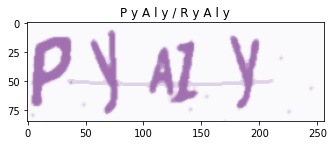

In [49]:
for (x, y) in test_dataloader:
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        y1 = list(map(lambda x: keys[x], y1))
        y2 = list(map(lambda x: keys[x], y2))
        y3 = list(map(lambda x: keys[x], y3))
        y4 = list(map(lambda x: keys[x], y4))
        y5 = list(map(lambda x: keys[x], y5))
        
        pred1 = list(map(lambda x: keys[x], pred1))
        pred2 = list(map(lambda x: keys[x], pred2))
        pred3 = list(map(lambda x: keys[x], pred3))
        pred4 = list(map(lambda x: keys[x], pred4))
        pred5 = list(map(lambda x: keys[x], pred5))
        
        
        for idx in range(BATCH_SIZE):
            true_str = f'{y1[idx]} {y2[idx]} {y3[idx]} {y4[idx]} {y5[idx]}'
            pred_str = f'{pred1[idx]} {pred2[idx]} {pred3[idx]} {pred4[idx]} {pred5[idx]}'
            plt.figure(figsize=(50,50))
            plt.subplot(8, 8, idx+1)
            plt.title(f'{true_str} / {pred_str}')
            plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        break